In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pywt
import utils
from tqdm import tqdm


class Lab08_op:

    def load_data(self):
        mat = utils.load_data("data_lab8.mat")
        kdata_fs = np.flip(mat["kfull"])
        kdata_us = np.flip(mat["kacc"])

        return kdata_fs, kdata_us

    def dwt2(
        self, x: np.ndarray, wavelet: str = "db4", mode: str = "periodization", level: int = 4, axes: tuple = (-2, -1)
    ) -> Tuple[np.ndarray, list]:
        """Discrete 2D wavelet transform

        Args:
            x (ndarray):                data to be transformed
            wavelet (str, optional):    wavelet to use. Defaults to 'db4'.
            mode (str, optional):       Signal extension mode. Defaults to 'periodization'.
            level (int, optional):      Decomposition level. Defaults to 4.
            axes (tuple, optional):     Axis over which to compute the DWT. Defaults to (-2, -1).

        Returns:
            Complex wavelet transformed data (coeff_arr, coeff_slice)
                - coeff_arr: Wavelet transform coefficient array.
                - coeff_slice: List of slices corresponding to each coefficient.
        """
        # Your code here ...
        coeff_arr_real, coeff_slice = pywt.coeffs_to_array(pywt.wavedec2(np.real(x),wavelet,mode,level,axes))
        coeff_arr_imag, coeff_slice = pywt.coeffs_to_array(pywt.wavedec2(np.imag(x),wavelet,mode,level,axes))
        coeff_arr = coeff_arr_real + 1j * coeff_arr_imag
        return coeff_arr, coeff_slice

    def idwt2(
        self, coeff_arr: np.ndarray, coeff_slice: list, wavelet: str = "db4", mode: str = "periodization"
    ) -> np.ndarray:
        """Inverse discrete 2D wavelet transform

        Args:
            coeff_arr (ndarray):        Wavelet transform coefficient array
            coeff_slice (list):         List of slices corresponding to each coefficient
            wavelet (str, optional):    wavelet to use. Defaults to 'db4'.
            mode (str, optional):       Signal extension mode. Defaults to 'periodization'.

        Returns:
            rec_complex (ndarray):      Reconstructed complex data
        """
        # Your code here ...
        arr_coeff_real = pywt.array_to_coeffs(np.real(coeff_arr),coeff_slice,output_format="wavedec2")
        arr_coeff_imag = pywt.array_to_coeffs(np.imag(coeff_arr),coeff_slice,output_format="wavedec2")
        rec_complex_real = pywt.waverec2(arr_coeff_real,wavelet,mode)
        rec_complex_imag = pywt.waverec2(arr_coeff_imag,wavelet,mode)
        rec_complex = rec_complex_real + 1j * rec_complex_imag
        return rec_complex

    def is_wt_sparser(self, gt: np.ndarray, coeff_arr_cmplx: np.ndarray) -> bool:
        """
        Is Wavelet Transform sparser than the ground truth?
        Compute the L1-norm of the ground truth and the wavelet transformed data.

        Args:
            gt (ndarray):               Ground truth image
            coeff_arr_cmplx (ndarray):  Complex wavelet transformed data

        Returns:
            bool:                       True if the wavelet transform is sparser than the ground truth
        """
        # Your code here ...

        l1_gt = np.sum(np.abs(gt))
        l1_wt = np.sum(np.abs(coeff_arr_cmplx))

        return l1_gt > l1_wt

    def compress(self, coeff_arr: np.ndarray, comp_factor: int) -> np.ndarray:
        """Compress wavelet coefficients by the comp_factor

        Args:
            coeff_arr (ndarray):        Wavelet coefficients
            comp_factor (int):          Compression factor

        Returns:
            coeff_arr:                  Compressed wavelet coefficients
        """
        # Your code here ...
        threshold_ind = np.size(coeff_arr) // comp_factor - 1
        if threshold_ind < 0:
                return np.zeros_like(coeff_arr,dtype=complex)
        new_arr = np.copy(coeff_arr)
        temp = np.flip(np.sort(np.abs(new_arr).flatten()))
        threshold = temp[threshold_ind]
        new_arr[np.abs(new_arr) < threshold] = 0
        return new_arr

    def calc_acc_rate(self, kdata_fs: np.ndarray, kdata_us: np.ndarray) -> float:
        """
        Calculate acceleration rate

        Args:
            kdata_fs (ndarray):         Fully sampled k-space data
            kdata_us (ndarray):         Undersampled k-space data

        Returns:
            acc_rate (float):           Acceleration rate
        """
        # Your code here ...

        acc_rate = kdata_fs.size / np.count_nonzero(kdata_us) 

        return acc_rate

    def get_sampling_mask(self, kdata_us: np.ndarray) -> np.ndarray:
        """
        Get the sampling mask

        Args:
            kdata_us (ndarray):         Undersampled k-space data

        Returns:
            mask (ndarray):             Sampling mask
        """
        # Your code here ...

        mask = np.zeros_like(kdata_us)
        mask[np.abs(kdata_us) > 0] = 1
        return mask

    def soft_threshold(self, coeff_arr: np.ndarray, lamda: float) -> np.ndarray:
        """
        Soft-threshold
        Look at the lecture note p.23

        Args:
            coeff_arr (ndarray):    Approximated coefficients
            lamda (float):          Threshold value

        Returns:
            Soft-thresholded coefficients
        """
        # Your code here ...
        thresholded = np.copy(coeff_arr)
        for idx in np.ndindex(coeff_arr.shape):
            if np.abs(thresholded[idx]) <= lamda:
                thresholded[idx] = 0
            else:
                x = thresholded[idx]
                thresholded[idx] = (x / np.abs(x)) * (np.abs(x) - lamda)
        return thresholded

    def calc_cost(self, kdata: np.ndarray, m_n: np.ndarray, mask: np.ndarray, lamda: float, **kwargs) -> float:
        """
        Calculate the cost function for the CS reconstruction

        Args:
            kdata (ndarray):        Undersampled kspace
            m_n (ndarray):          Reconstructed image at n-th iteration
            mask (ndarray):         Sampling mask
            lamda (float):          Regularization parameter

        Returns:
            cost (float):              Cost function value
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        dwt2 = kwargs.get("dwt2", self.dwt2)

        # Your code here ...
        temp1 = utils.fft2c(m_n)*mask - kdata
        temp2, _ = dwt2(m_n)

        cost1 = np.sum(np.abs(temp1)**2)  
        cost2 = np.sum(np.abs(temp2))           ########################################## this is correct
        #cost2 = np.linalg.norm(temp2,ord=1) ############################################## this is wrong!!!!!

        cost = cost1 + lamda * cost2
        return cost

    def cs_ista_1(self, m_n: np.ndarray, mask: np.ndarray) -> np.ndarray:
        return mask * utils.fft2c(m_n)

    def cs_ista_2(self, Em: np.ndarray, d: np.ndarray) -> np.ndarray:
        return Em - d

    def cs_ista_3(self, Em_d: np.ndarray) -> np.ndarray:
        return utils.ifft2c(Em_d)

    def cs_ista_4(self, m_n: np.ndarray, EhDC: np.ndarray) -> np.ndarray:
        return m_n - EhDC

    def cs_ista_5(self, m_n_EhDC: np.ndarray, **kwargs) -> np.ndarray:
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        dwt2 = kwargs.get("dwt2", self.dwt2)

        return dwt2(m_n_EhDC)

    def cs_ista_6(self, T: np.ndarray, lamda: float, **kwargs) -> np.ndarray:
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        soft_threshold = kwargs.get("soft_threshold", self.soft_threshold)

        return soft_threshold(T,lamda)

    def cs_ista_7(self, S: np.ndarray, slices: list, **kwargs) -> np.ndarray:
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        idwt2 = kwargs.get("idwt2", self.idwt2)

        return idwt2(S,slices)

    def cs_ista(
        self, kdata: np.ndarray, lamda_percent: float, n_it: int, show_pbar: bool = True, **kwargs
    ) -> np.ndarray:
        """
        Compressed Sensing using the iterative soft-threshold algorithm
        Look at the lecture note p.23

        Args:
            kdata (ndarray):        Undersampled kspace
            lamda_percent (float):  Regularization parameter [%]
            n_it (int):             Maximum iteration number

        Returns:
            m (ndarray):            CS reconstructed image
            inter_m (list):         A list containing the initial solution and the CS reconstructed image
            costs (list):           A list containing the cost at each iteration
        """
        # PLEASE IGNORE HERE AND DO NOT MODIFY THIS PART.
        # To use nest kwargs, you can use the following code.
        # calc_cost(..., dwt2=kwargs.get("dwt2", self.dwt2))
        get_sampling_mask = kwargs.get("get_sampling_mask", self.get_sampling_mask)
        dwt2 = kwargs.get("dwt2", self.dwt2)

        calc_cost = kwargs.get("calc_cost", self.calc_cost)
        cs_ista_1 = kwargs.get("cs_ista_1", self.cs_ista_1)
        cs_ista_2 = kwargs.get("cs_ista_2", self.cs_ista_2)
        cs_ista_3 = kwargs.get("cs_ista_3", self.cs_ista_3)
        cs_ista_4 = kwargs.get("cs_ista_4", self.cs_ista_4)
        cs_ista_5 = kwargs.get("cs_ista_5", self.cs_ista_5)
        cs_ista_6 = kwargs.get("cs_ista_6", self.cs_ista_6)
        cs_ista_7 = kwargs.get("cs_ista_7", self.cs_ista_7)

        lamda = lamda_percent / 100 

        mask = get_sampling_mask(kdata)
        m_n = utils.ifft2c(kdata)  # Initial solution 
        tt, _ = dwt2(m_n)
        threshold = lamda * np.max(np.abs(tt))

        inter_m, costs = [], []

        if show_pbar:
            pbar = tqdm(total=n_it, unit="iter", leave=True)

        for it in range(n_it):
            inter_m.append(abs(m_n))

            # Iterative Soft Threshold Compressed Sensing Algorithm
            # Your code here ...

            # Calculate the cost
            cost = calc_cost(kdata,m_n,mask,lamda)
            costs.append(cost)

            # Update the solution
            # Your code here ...
            temp1 = cs_ista_1(m_n, mask)               ####################################################################
            temp2 = cs_ista_2(temp1, kdata)            ####################################################################
            temp3 = cs_ista_3(temp2)                   ####################################################################  
            temp4 = cs_ista_4(m_n,temp3)               ####################################################################
            temp5, slices = cs_ista_5(temp4)           ####################################################################
            temp6 = cs_ista_6(temp5,threshold)         ####################################################################
            m_n = cs_ista_7(temp6, slices)             ####################################################################
            inter_m.append(abs(m_n))                    ###################################################################

            if show_pbar:
                pbar.set_description(desc=f"Iteration {it: 2d}")
                pbar.set_postfix({"Cost": f"{cost: .5f}"})
                pbar.update()

        
        return m_n, inter_m, costs[1:]                  ############### will three returns be evaluated separately???????

In [2]:
op = Lab08_op()
kdata_fs, kdata_us = op.load_data()

In [3]:
gt = utils.ifft2c(kdata_fs)
c_real = pywt.wavedec2(np.real(gt), wavelet="db4")
c_real_array, coeff_slice = pywt.coeffs_to_array(c_real)

In [4]:
gt = utils.ifft2c(kdata_fs)
coeff_arr_cmplx, coeff_slice = op.dwt2(gt)

# utils.imshow([gt], titles=["Ground truth"])
# utils.imshow([coeff_arr_cmplx], titles=["WT coefficients"], norm=0.3)

In [234]:
print("Is the wavelet transform sparser than the ground truth?")
print(op.is_wt_sparser(gt, coeff_arr_cmplx))

Is the wavelet transform sparser than the ground truth?
True


In [235]:
C = [5, 10, 20]
recons = []
for factor in C:
    compressed = op.compress(coeff_arr_cmplx.copy(), factor)
    recon = op.idwt2(compressed, coeff_slice)
    recons.append(recon)

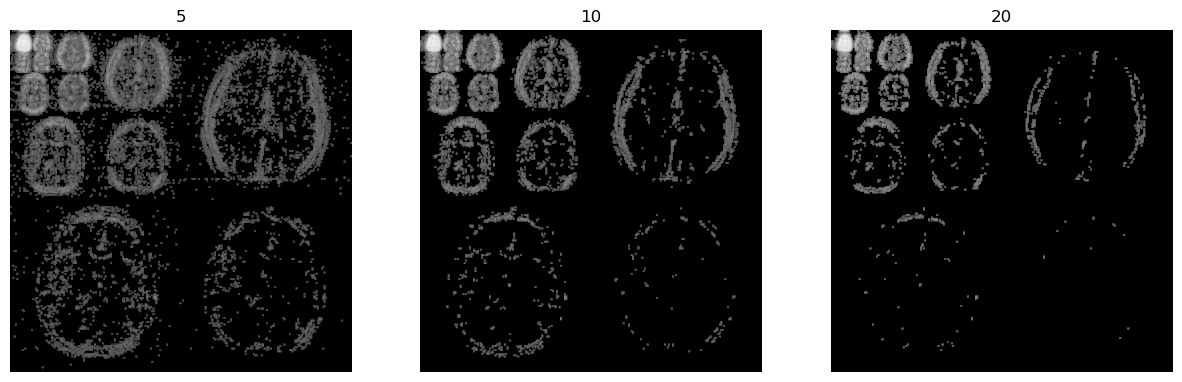

In [236]:
C = [5, 10, 20]

compressed1 = op.compress(coeff_arr_cmplx.copy(), 5)
compressed2 = op.compress(coeff_arr_cmplx.copy(), 10)
compressed3 = op.compress(coeff_arr_cmplx.copy(), 20)

utils.imshow([compressed1, compressed2, compressed3], titles=C, norm=0.2)

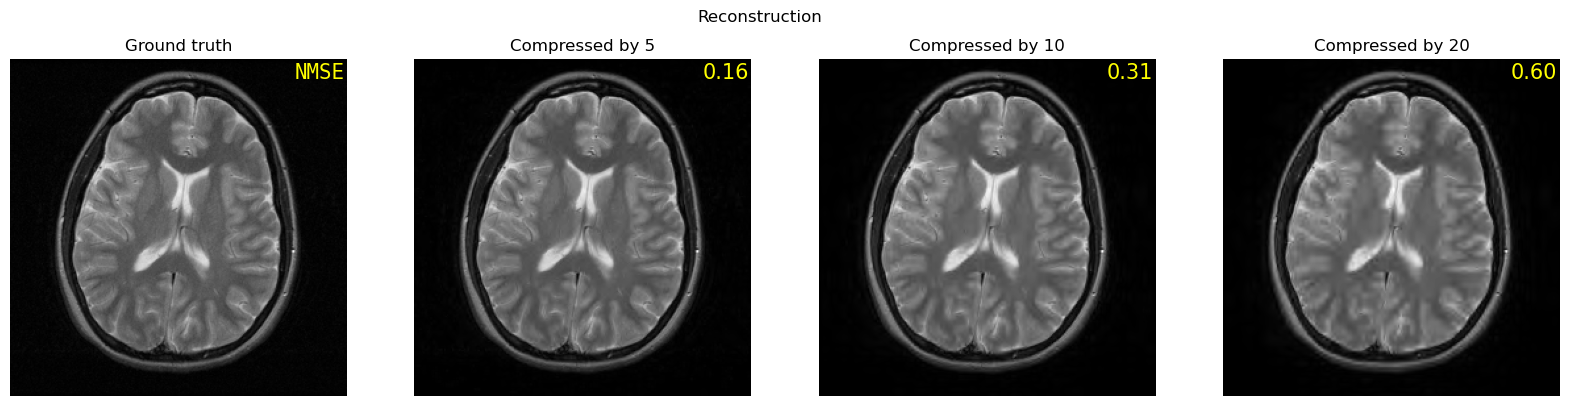

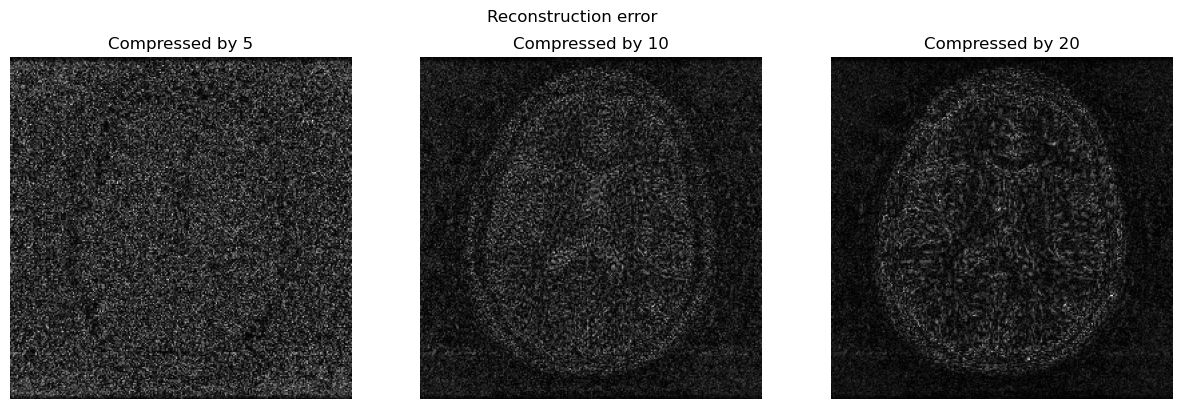

In [237]:
norm_gt = utils.normalization(np.abs(gt))
diff_imgs = [norm_gt - utils.normalization(np.abs(i)) for i in recons]

utils.imshow(recons, gt=gt, titles=[f"Compressed by {factor}" for factor in C], suptitle="Reconstruction")
utils.imshow(
    diff_imgs,
    titles=[f"Compressed by {factor}" for factor in C],
    suptitle="Reconstruction error",
)

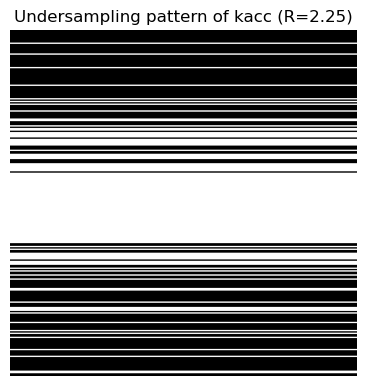

In [5]:
acc_ratio = np.count_nonzero(kdata_us) / kdata_fs.size
acc = 1 / acc_ratio
sampling_mask = op.get_sampling_mask(kdata_us)
utils.imshow([sampling_mask], titles=[f"Undersampling pattern of kacc (R={acc:.2f})"])

Iteration  29: 100%|██████████| 30/30 [00:03<00:00,  8.47iter/s, Cost=417.77473]


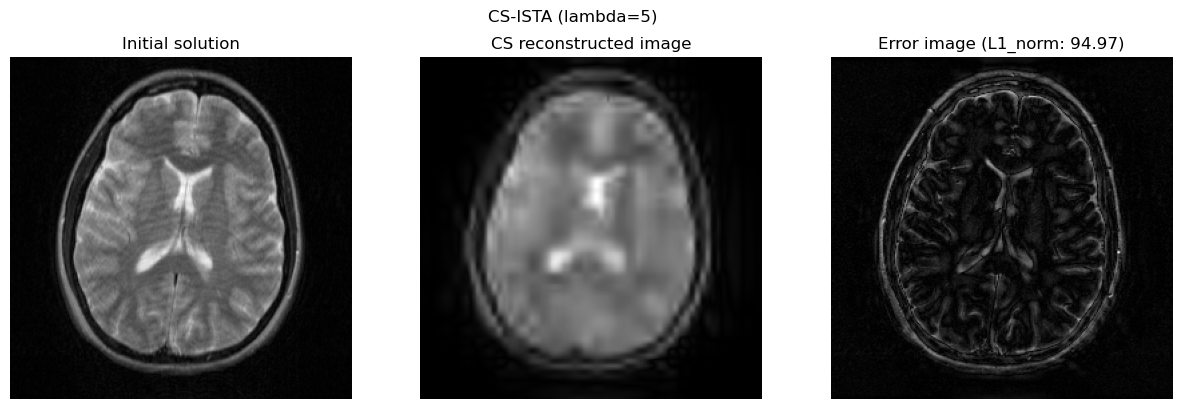

Iteration  29: 100%|██████████| 30/30 [00:03<00:00,  8.78iter/s, Cost=94.01534]


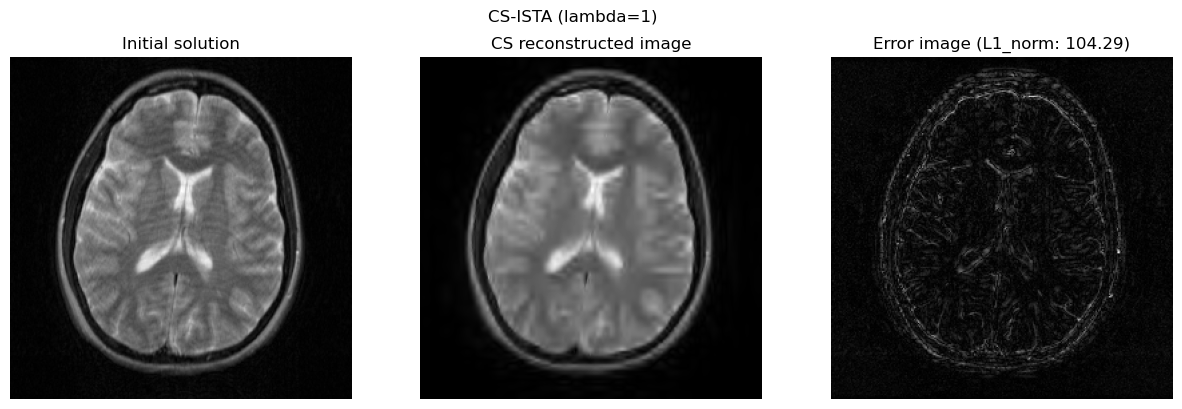

Iteration  29: 100%|██████████| 30/30 [00:03<00:00,  8.50iter/s, Cost=46.75173]


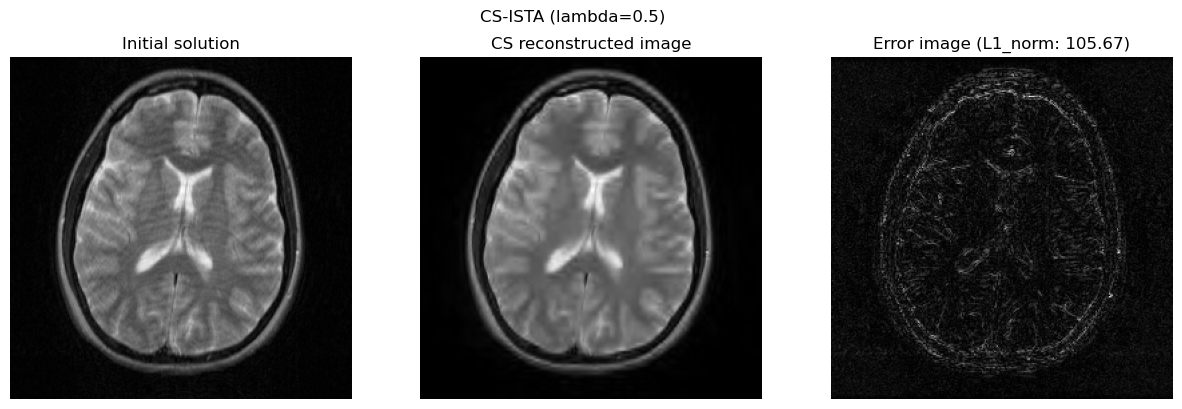

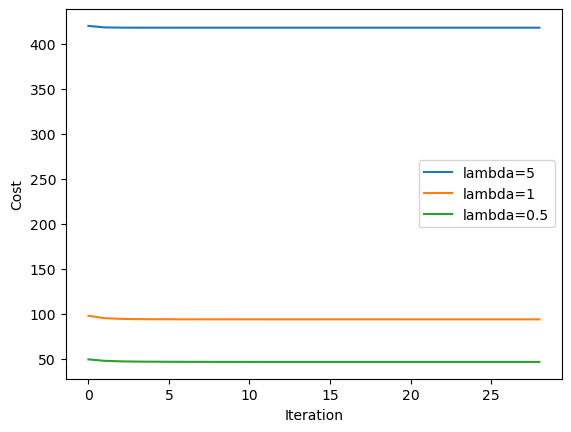

In [6]:
lamdas = [5, 1, 0.5]
cost_list = []
for i, lamda in enumerate(lamdas, start=1):
    rec, inter_m, costs = op.cs_ista(kdata_us, lamda, 30)
    utils.create_gif(inter_m, f"CS-{i}")
    utils.imshow(
        [inter_m[0], rec, np.abs(gt) - (np.abs(rec))],
        titles=[
            "Initial solution",
            "CS reconstructed image",
            f"Error image (L1_norm: {np.linalg.norm(rec,ord=1):.2f})",
        ],
        suptitle=f"CS-ISTA (lambda={lamda})",
    )
    cost_list.append(costs)

f, a = plt.subplots()
for cost, lamda in zip(cost_list, lamdas):
    a.plot(cost, label=f"lambda={lamda}")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()